In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications as kapp
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers as kl
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import cv2
import os
import imageio
from tensorflow_docs.vis import embed

In [30]:
IMG_SIZE = 224
INPUT_SIZE = (IMG_SIZE, IMG_SIZE, 3)

SEQ_LENGTH = 20
DATASET_DIR = r'data\UCF-101'
NUM_FEATURES = 2048
EPOCHS = 32

In [5]:
# source:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [6]:
#frames extraction

def frames_extraction(path, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    video_lenght = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(int(video_lenght/SEQ_LENGTH), 1)

    try:
        for i in range(SEQ_LENGTH):
            cap.set(cv2.CAP_PROP_FRAME_COUNT, i*interval)
            success, frame = cap.read()

            if not success:
                break

            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            normalized_frame = frame / 255
            frames.append(normalized_frame)
    finally:
        cap.release()

    return np.array(frames)

In [7]:
def create_cnn_model():
    input = tf.keras.Input(INPUT_SIZE)
    cnn = kapp.ResNet50(pooling="avg", include_top = False, weights='imagenet', input_shape = INPUT_SIZE)
    
    preprocessed = preprocess_input(input)

    output = cnn(preprocessed)
    cnn_model = tf.keras.Model(input, output, name="ResNet50")

    cnn_model.summary()
    
    return cnn_model

In [8]:
cnn_model = create_cnn_model()



Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


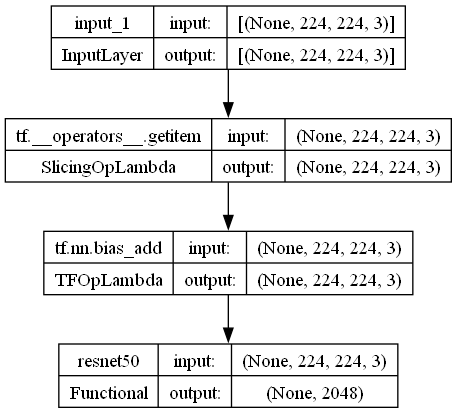

In [26]:
utils.plot_model(cnn_model, to_file="resnet50_structure_plot.png", show_shapes=True, show_layer_names=True)

In [9]:
#data preparation

test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

label = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
label_vocab = label.get_vocabulary()
print(label_vocab)

['PlayingCello', 'Punch']


In [10]:
def feature_extraction(df, dir):
    samples = len(df)
    labels = df["tag"].values
    labels = (label(labels[..., None])).numpy()
    
    frame_masks = np.zeros(shape=(samples, SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(samples, SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    indx = 0

    for class_name in (label_vocab):
        video_names = df.loc[df["tag"] == class_name]["video_name"]
        for video_idx, video_name in enumerate(video_names):
            video_path = os.path.join(dir, class_name, video_name)
            frames = frames_extraction(video_path)
            frames = frames[None, ...]

            temp_frame_mask = np.zeros(shape=(1, SEQ_LENGTH,), dtype="bool",)
            temp_frame_features = np.zeros(shape=(1, SEQ_LENGTH, NUM_FEATURES), dtype="float32")

            for i, batch in enumerate(frames):
                video_length = batch.shape[0]
                length = min(SEQ_LENGTH, video_length)
                for j in range(length):
                    temp_frame_features[i, j, :] = cnn_model.predict(batch[None, j, :], verbose=0,)
                temp_frame_mask[i, :length] = 1

            frame_features[indx+video_idx,] = temp_frame_features.squeeze()
            frame_masks[indx+video_idx,] = temp_frame_mask.squeeze()
            
        indx += len(video_names)

    return (frame_features, frame_masks), labels

In [11]:
train_data, train_labels = feature_extraction(train_df, DATASET_DIR)
test_data, test_labels = feature_extraction(test_df, DATASET_DIR)

In [16]:
#create model

def create_model():
    input_mask = keras.Input((SEQ_LENGTH, ), dtype="bool")
    input_features = keras.Input((SEQ_LENGTH, NUM_FEATURES))
    inputs = [input_features, input_mask]

    x = kl.LSTM(64, return_sequences=True)(input_features, mask=input_mask)
    x = kl.LSTM(32, return_sequences=True)(x)
    x = kl.LSTM(16)(x)
    x = kl.Dropout(0.4)(x)
    output = kl.Dense(len(label_vocab), activation="softmax")(x)
    model = keras.Model([inputs], output, name="LSTM_Model")

    model.summary()
    return model

In [17]:
model = create_model()

Model: "LSTM_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 20, 2048)]           0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 20, 64)               540928    ['input_6[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               (None, 20, 32)               12416     ['lstm_3[0][0]']     

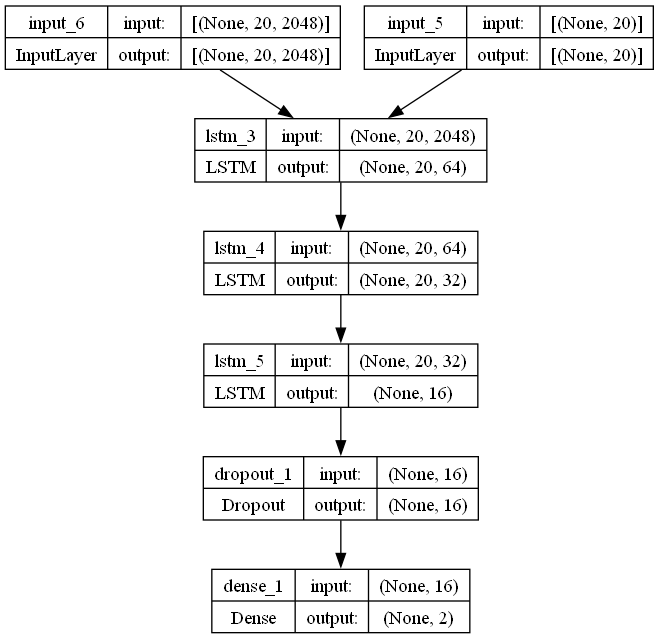

In [18]:
utils.plot_model(model, to_file="lstm_model_structure_plot.png", show_shapes=True, show_layer_names=True)

In [48]:
filepath = "/tmp/video_classifier/ckpt.weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

early_stooping_callback = keras.callbacks.EarlyStopping(monitor="accuracy", patience=10, mode="min", restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
model_training_history = model.fit(x=[train_data[0], train_data[1]], y=train_labels, epochs=EPOCHS, validation_split=0.3, callbacks = [checkpoint])

Epoch 1/32
5/6 [========================>.....] - ETA: 0s - loss: 0.5540 - accuracy: 0.7312
Epoch 1: val_loss improved from inf to 1.33097, saving model to /tmp/video_classifier\ckpt.weights.h5
6/6 [==============================] - 16s 837ms/step - loss: 0.5468 - accuracy: 0.7321 - val_loss: 1.3310 - val_accuracy: 0.0000e+00
Epoch 2/32
5/6 [========================>.....] - ETA: 0s - loss: 0.3452 - accuracy: 0.8687
Epoch 2: val_loss improved from 1.33097 to 0.55067, saving model to /tmp/video_classifier\ckpt.weights.h5
6/6 [==============================] - 0s 65ms/step - loss: 0.3408 - accuracy: 0.8750 - val_loss: 0.5507 - val_accuracy: 0.7260
Epoch 3/32
5/6 [========================>.....] - ETA: 0s - loss: 0.2175 - accuracy: 0.9375
Epoch 3: val_loss did not improve from 0.55067
6/6 [==============================] - 0s 54ms/step - loss: 0.2157 - accuracy: 0.9405 - val_loss: 1.2059 - val_accuracy: 0.5890
Epoch 4/32
5/6 [========================>.....] - ETA: 0s - loss: 0.2156 - accu

In [50]:
#evaluation
_, model_evaluation = model.evaluate([test_data[0], test_data[1]], test_labels)
print(f"Accuracy: {round(model_evaluation * 100, 2)}%")

3/3 [==============================] - 0s 14ms/step - loss: 0.6276 - accuracy: 0.8193
Accuracy: 81.93%


In [54]:
#loss & accuracy

def plot_compare(model_history, metric_1, metric_2, title):
    value_1 = model_history.history[metric_1]
    value_2 = model_history.history[metric_2]
    x = range(len(value_1))

    plt.plot(x, value_1, label=metric_1)
    plt.plot(x, value_2, label=metric_2)
    plt.grid(True)
    plt.title(title)
    plt.legend()

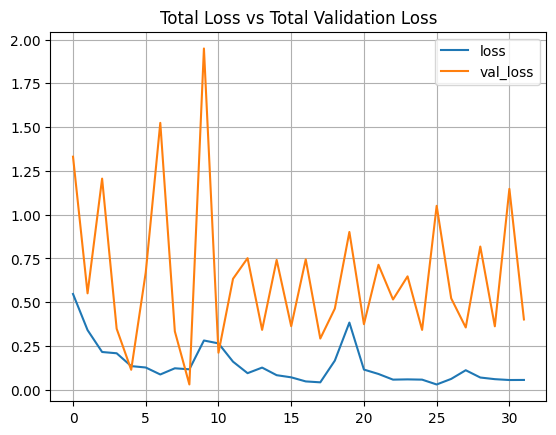

In [55]:
plot_compare(model_training_history, "loss", "val_loss", "Total Loss vs Total Validation Loss")

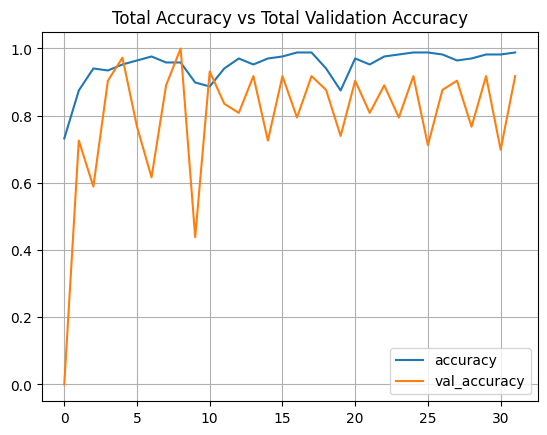

In [56]:
plot_compare(model_training_history, "accuracy", "val_accuracy", "Total Accuracy vs Total Validation Accuracy")